# K-NN On Amazon Fine Food Reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


### Objective
* To classify the positive and negative reviews.

###  How to classify?
* By applying vectorization techniques such as BOW, TF-IDF , Avg W2V and TF-IDF weighted W2V.
* Applying K-nn on above vectors. 
* Column used to check the Acuracy will be Score.
  - Positive review (rating 4-5)
  - Negative review (rating 1-2)

## Loading Data

In [1]:
%matplotlib inline
import warnings as wr
wr.filterwarnings('ignore')

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

con = sqlite3.connect('database.sqlite') #building connnection with database
review_data = pd.read_sql_query('''select * from Reviews where Score != 3''',con)#importing data from database

#function to replace rating with 1(+ve) or 0(-ve)
def Replace_rate(x):
    if x < 3:
        return 0
    else:
        return 1

OldScore = review_data['Score']
NewScore = OldScore.map(Replace_rate)
review_data['Score'] = NewScore
print('Review data is loaded with {0} rows and {1} columns'.format(review_data.shape[0],review_data.shape[1]))
review_data.head()



Review data is loaded with 525814 rows and 10 columns


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Preprocessing

### Removing duplicate data

In [2]:
#Checking for duplicate data 
duplicate_data = pd.read_sql_query('''select UserId, ProductId, ProfileName, Time, Score, Text, count(*) as count from Reviews where 
Score != 3 group by UserId having count(*) > 1 ''',con)

duplicate_data.shape

(75346, 7)

In [3]:
#removing duplicate data
print('Data before de-duplication had {} rows and {} columns'.format(review_data.shape[0],review_data.shape[1]))
review_data = review_data.sort_values('ProductId',axis = 0, ascending=True, inplace=False, kind='quicksort', na_position='last')

review_data = review_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print('Data after de-duplication had {} rows and {} columns'.format(review_data.shape[0],review_data.shape[1]))

Data before de-duplication had 525814 rows and 10 columns
Data after de-duplication had 364173 rows and 10 columns


In [4]:
# Helpfulness denominator should be always greater than numerator
review_data = review_data[review_data.HelpfulnessNumerator <= review_data.HelpfulnessDenominator]
review_data.shape

(364171, 10)

### Cleaning the data
* Removing html tags
* Removing stopwords
* Converting words to lower case
* Removing alphanumeric value 
* Lemmitizing the data

In [5]:
import re
import os
import nltk
import string
from tqdm import tqdm
from nltk.corpus import stopwords 

sno = nltk.stem.SnowballStemmer('english')#initialise stemmer
stop = set(stopwords.words('english'))

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


if not os.path.isfile('final.sqlite'):
    final_string = []
    for i, sent in enumerate(tqdm(review_data['Text'].values)):
        filtered_sentence=[]
        sent = cleanhtml(sent)
        for w in sent.split():
            for cleanwords in cleanpunc(w).split():
                #we are spliting the data two time because after first splitting there may be a possibility that we can get a word
                # 'abc.def' which after the second split will become two words 'abc' 'def'
                if((cleanwords.isalpha()) and (len(cleanwords)>2)): # there is no adjective with length 2
                    if(cleanwords.lower() not in stop):
                        s=(sno.stem(cleanwords.lower())).encode('utf8')
                        filtered_sentence.append(s)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
        

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [05:22<00:00, 1130.86it/s]


In [6]:
#storing the data in a database(.sqlite file)
review_data['CleanedText'] = final_string
review_data['CleanedText']=review_data['CleanedText'].str.decode("utf-8")
conn = sqlite3.connect('final.sqlite')
c = conn.cursor()
conn.text_factory = str
review_data.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
conn.close()

In [7]:
#importing preprocessed data into a new dataframe
conn = sqlite3.connect('final.sqlite')
preprocessed_data = pd.read_sql_query('''select * from Reviews limit 100000''',conn)
print(preprocessed_data.shape)
preprocessed_data.head()

(100000, 12)


,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witti littl book make son laugh loud recit car...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew read sendak book watch realli rosi movi i...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,1,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,fun way children learn month year learn poem t...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,1,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,great littl book read nice rhythm well good re...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,1,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,book poetri month year goe month cute littl po...


In [8]:
#https://www.programiz.com/python-programming/datetime/strftime
#converting given time with format %m/%d/%Y, %H:%M:%S
from datetime import datetime

timestamp = preprocessed_data['Time']
time_data=[]
for i in timestamp:
    date_time = datetime.fromtimestamp(i)
    d = date_time.strftime("%m/%d/%Y, %H:%M:%S")
    time_data.append(d)

preprocessed_data['Time'] = time_data

#sorting values according to time for the time base splitting
processed_data = preprocessed_data.sort_values('Time',axis=0).reset_index(drop=True)
processed_data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,516061,557949,B0000DJDL4,A1Y20KNCR0SZA1,"Dessartfamily ""grandmasoven""",8,9,1,"01/01/2004, 05:30:00",The best Kringles ever,Others try to make kringles but there is only ...,other tri make kringl one bakeri make real dan...
1,77542,84346,B0000DGF5S,AQDTYG93O2WYO,Paul L. Bardzik,15,16,0,"01/01/2006, 05:30:00",Broken pot,"Not sure if the plant is going to survive, The...",sure plant go surviv pot broken open box yet s...
2,309826,335493,B0002HVDNY,A3FVAWZNKW9GX,"A.Trendl HungarianBookstore.com ""What should ...",1,2,1,"01/01/2006, 05:30:00",Slowly Smoked Pork is Delicious,I buy Karaj Hungarian Pork Loin regularly at o...,buy karaj hungarian pork loin regular local hu...
3,242022,262487,B0007KLGC4,A2RV24L38GOIGT,Mark L. White,8,9,1,"01/01/2006, 05:30:00",best candy,Mallo Cup candy is the best candy that has eve...,mallo cup candi best candi ever made put marke...
4,208995,226507,B000A3I3BA,A7GXT5V1VL5UT,"J. Leigh ""jleigh7""",74,75,1,"01/01/2006, 05:30:00",Major time and effort saver,REMEMBER THE OLD WAY OF STIRRING PEANUT BUTTER...,rememb old way stir peanut butter think youv e...


### Splitting Data

In [9]:
#splitting the data into train and test set
#for linear kernel
from sklearn.model_selection import train_test_split

X = processed_data['CleanedText']
Y = processed_data['Score']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.33)


data = processed_data.copy()
data = data.iloc[:20000,:]
X = data['CleanedText']
Y = data['Score']
x_train_rbf, x_test_rbf, y_train_rbf, y_test_rbf = train_test_split(X, Y, test_size=0.33)

### Function for Finding Optimal C

In [10]:
# this function is defined to reduce the coding effort to find k value for each vectorization technique
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit
import math
def optimal_lambda_val(x,y,model,parameters):
    
    #https://stackoverflow.com/questions/53252832/how-to-find-top-features-from-naive-bayes-using-sklearn-pipeline
    clf = GridSearchCV(model, parameters, cv=3, scoring='roc_auc')
    clf.fit(x, y)
    
    train_auc= clf.cv_results_['mean_train_score']
    train_auc_std= clf.cv_results_['std_train_score']
    cv_auc = clf.cv_results_['mean_test_score'] 
    cv_auc_std= clf.cv_results_['std_test_score']
    
    print('Best tunned parameter is',clf.best_params_)
    print('Train data accuracy is %f%% '%(clf.best_score_*100))
    
    plt.plot(alpha, train_auc, label='Train AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(alpha,train_auc - train_auc_std,train_auc + train_auc_std,alpha=0.2,color='darkblue')
    
    plt.plot(alpha, cv_auc, label='CV AUC')
    # this code is copied from here: https://stackoverflow.com/a/48803361/4084039
    plt.gca().fill_between(alpha,cv_auc - cv_auc_std,cv_auc + cv_auc_std,alpha=0.2,color='darkorange')
    plt.legend()
    plt.xlabel("hyperparameter")
    plt.ylabel("AUC")
    plt.title("ERROR PLOTS")
    plt.show()
    return clf.best_params_

In [11]:
a = [.0001,.001,.01,1,10,100,1000]
alpha = [math.log(i) for i in a]
parameters_linear = {'alpha': a}
parameters_rbf = {'C': a}

## Bag Of Words

In [12]:
#vectorizing train data for BOW
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
x_train_bow = count_vect.fit_transform(x_train)
x_test_bow = count_vect.transform(x_test)
print(x_train_bow.shape)
print(x_test_bow.shape)

(67000, 30910)
(33000, 30910)


### Linear Kernel

Best tunned parameter is {'alpha': 0.001}
Train data accuracy is 92.558489% 


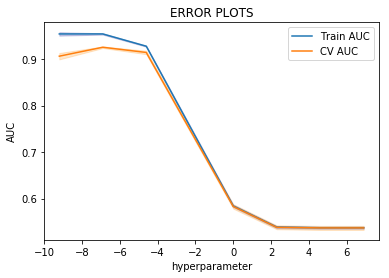

In [13]:
optimal_alpha=optimal_lambda_val(x=x_train_bow,y=y_train,model = SGDClassifier(),parameters=parameters_linear)

### Testing alpha on test data

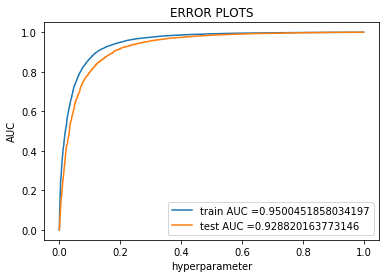

In [14]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

sgd = SGDClassifier(alpha=optimal_alpha['alpha'])
sgd.fit(x_train_bow,y_train)
clf = CalibratedClassifierCV(base_estimator = sgd,cv = 'prefit')
clf.fit(x_train_bow, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix on Train Data

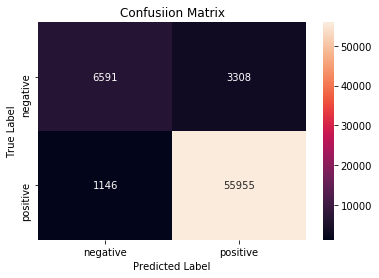

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.85      0.67      0.75      9899
          1       0.94      0.98      0.96     57101

avg / total       0.93      0.93      0.93     67000



In [15]:
# predict the response
y_pred_bow = clf.predict(x_train_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')

print(classification_report(y_train ,y_pred_bow))

### Confusion Matrix on Test  Data

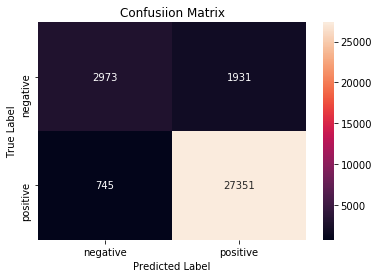

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.80      0.61      0.69      4904
          1       0.93      0.97      0.95     28096

avg / total       0.91      0.92      0.91     33000



In [16]:
# predict the response
y_pred_bow = clf.predict(x_test_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')

print(classification_report(y_test ,y_pred_bow))

### Top 10 Positive and Negative Features

In [17]:
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def important_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\tNegative\t\t\t\t\tPositive")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
important_features(count_vect,sgd)

		Negative					Positive
	-1.0204	worst          				0.5848	delici         
	-0.9100	disappoint     				0.5549	amaz           
	-0.8592	aw             				0.5460	perfect        
	-0.8563	terribl        				0.5161	excel          
	-0.7697	threw          				0.5012	great          
	-0.7399	return         				0.4982	addict         
	-0.6802	unfortun       				0.4774	best           
	-0.6623	disgust        				0.4684	worri          
	-0.6415	horribl        				0.4624	nice           
	-0.5937	wast           				0.4505	awesom         


### RBF Kernel

Best tunned parameter is {'C': 10}
Train data accuracy is 88.451632% 


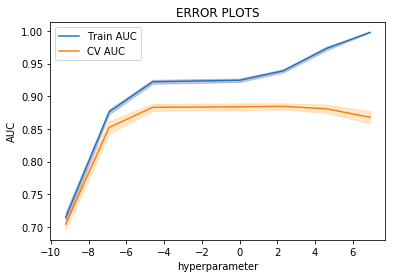

In [18]:
# using less features
import warnings as wr
wr.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler

count_vect = CountVectorizer(min_df = 10,max_features = 500)
x_train_bow = count_vect.fit_transform(x_train_rbf)
x_test_bow = count_vect.transform(x_test_rbf)

#finding best hyperparameter 
optimal_c = optimal_lambda_val(x=x_train_bow,y=y_train_rbf,model = SVC(),parameters = parameters_rbf)


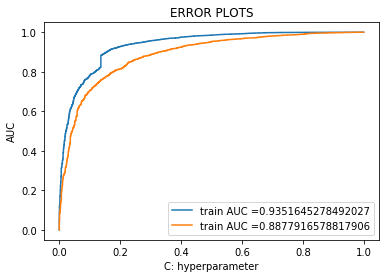

In [20]:
# instantiate learning model k = optimal_k
clf = SVC(C=optimal_c['C'],probability = True)
clf.fit(x_train_bow, y_train_rbf)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train_rbf, clf.predict_proba(x_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_rbf, clf.predict_proba(x_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix for Train data

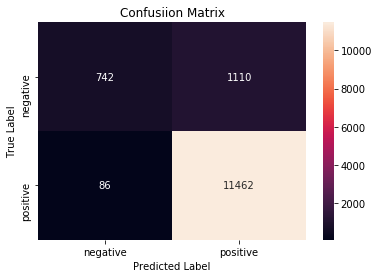

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.90      0.40      0.55      1852
          1       0.91      0.99      0.95     11548

avg / total       0.91      0.91      0.90     13400



In [21]:
# predict the response
y_pred_bow = clf.predict(x_train_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train_rbf,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_train_rbf ,y_pred_bow))

### Confusion Matrix on Test Data

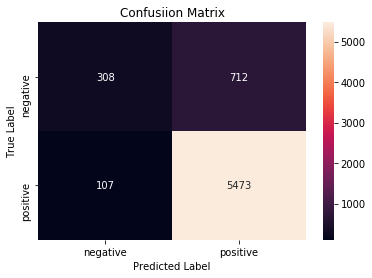

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.74      0.30      0.43      1020
          1       0.88      0.98      0.93      5580

avg / total       0.86      0.88      0.85      6600



In [22]:
# predict the response
y_pred_bow = clf.predict(x_test_bow)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test_rbf,y_pred_bow)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_test_rbf ,y_pred_bow))

## TF-IDF

### Linear Kernel

In [23]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
x_train_tfidf = tf_idf_vect.fit_transform(x_train)
x_test_tfidf = tf_idf_vect.transform(x_test)
print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

(67000, 39052)
(33000, 39052)


Best tunned parameter is {'alpha': 0.0001}
Train data accuracy is 94.972898% 


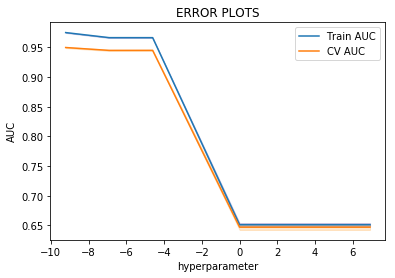

In [24]:
#getting optimal_k value
optimal_alpha = optimal_lambda_val(x=x_train_tfidf,y=y_train,model = SGDClassifier(),parameters = parameters_linear)

### Testing alpha on test data

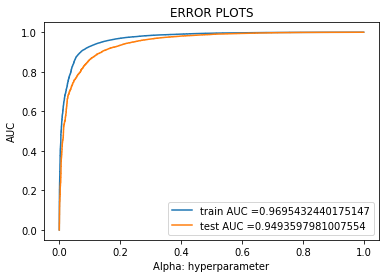

In [25]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

sgd = SGDClassifier(alpha=optimal_alpha['alpha'])
sgd.fit(x_train_tfidf, y_train)
clf = CalibratedClassifierCV(base_estimator = sgd,cv = 'prefit')
clf.fit(x_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix on Train Data

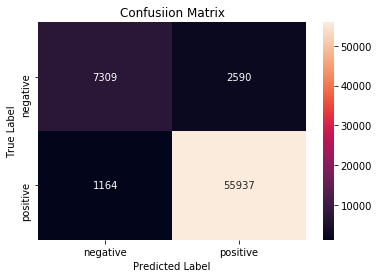

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.86      0.74      0.80      9899
          1       0.96      0.98      0.97     57101

avg / total       0.94      0.94      0.94     67000



In [26]:
# predict the response
y_pred_tfidf = clf.predict(x_train_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_train ,y_pred_tfidf))

### Confusion Matrix on Test Data

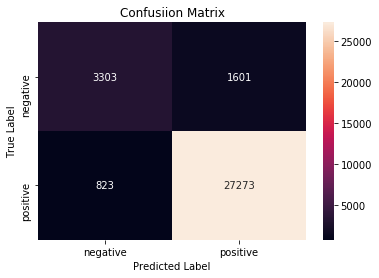

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.80      0.67      0.73      4904
          1       0.94      0.97      0.96     28096

avg / total       0.92      0.93      0.92     33000



In [27]:
# predict the response
y_pred_tfidf = clf.predict(x_test_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_test ,y_pred_tfidf))

### Top 10 Positive and Negative features

In [28]:
# https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers
def important_features(vectorizer, clf, n=10):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    print("\t\tNegative\t\t\t\t\tPositive")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
important_features(tf_idf_vect,sgd)

		Negative					Positive
	-4.6703	disappoint     				3.2836	great          
	-3.6177	worst          				2.7818	love           
	-3.3728	return         				2.7065	best           
	-3.1585	aw             				2.5373	delici         
	-3.0736	terribl        				2.1394	good           
	-2.9020	threw          				2.0683	perfect        
	-2.7828	horribl        				1.9719	nice           
	-2.5560	wast           				1.8625	excel          
	-2.4033	unfortun       				1.7461	amaz           
	-2.3325	money          				1.6036	wont disappoint


### Rbf Kernel

Best tunned parameter is {'C': 100}
Train data accuracy is 88.945069% 


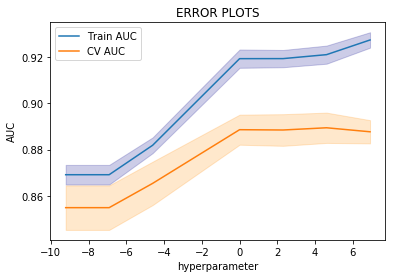

In [29]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features = 500)
x_train_tfidf = tf_idf_vect.fit_transform(x_train_rbf)
x_test_tfidf = tf_idf_vect.transform(x_test_rbf)

optimal_c = optimal_lambda_val(x=x_train_tfidf,y=y_train_rbf,model = SVC(),parameters = parameters_rbf)

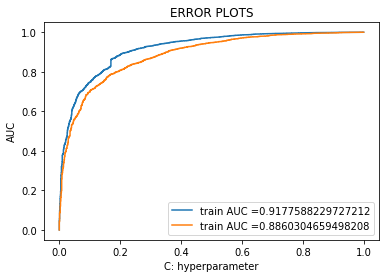

In [30]:
clf = SVC(C=optimal_c['C'],probability = True)
clf.fit(x_train_tfidf, y_train_rbf)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train_rbf, clf.predict_proba(x_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_rbf, clf.predict_proba(x_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()


### Confusion Matrix on Train Data

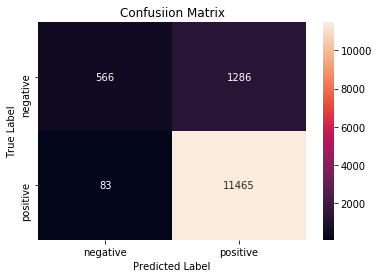

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.87      0.31      0.45      1852
          1       0.90      0.99      0.94     11548

avg / total       0.90      0.90      0.88     13400



In [31]:
# predict the response
y_pred_tfidf = clf.predict(x_train_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_train_rbf,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_train_rbf ,y_pred_tfidf))

### Confusion Matrix on Test Data

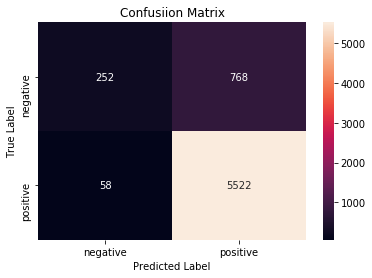

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.81      0.25      0.38      1020
          1       0.88      0.99      0.93      5580

avg / total       0.87      0.87      0.85      6600



In [32]:
# predict the response
y_pred_tfidf = clf.predict(x_test_tfidf)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(y_test_rbf,y_pred_tfidf)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_test_rbf ,y_pred_tfidf))

## Avg W2V

### Creating W2V for train data

In [39]:
#function for creating avg word2vector
from gensim.models import Word2Vec


list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

x_train_avgw2v = np.array(sent_vectors)


### Using Train Model to vectorize Test data

In [41]:
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

x_test_avgw2v = np.array(sent_vectors)


### Linear Kernel

(67000, 50)
(33000, 50)
Best tunned parameter is {'alpha': 0.01}
Train data accuracy is 90.244803% 


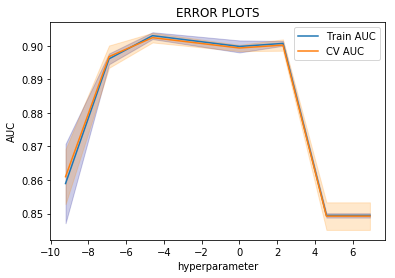

In [43]:
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
x_train_avgw2v_stand = scale.fit_transform(x_train_avgw2v)
x_test_avgw2v_stand = scale.transform(x_test_avgw2v)
print(x_train_avgw2v_stand.shape)
print(x_test_avgw2v_stand.shape)

#getting optimal_k value
optimal_alpha = optimal_lambda_val(x=x_train_avgw2v_stand,y=y_train,model = SGDClassifier(),parameters = parameters_linear)

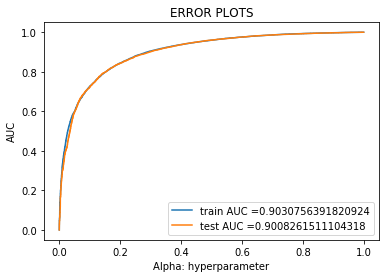

In [47]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

sgd = SGDClassifier(alpha=optimal_alpha['alpha'])
sgd.fit(x_train_avgw2v_stand, y_train)
clf = CalibratedClassifierCV(base_estimator = sgd,cv = 'prefit')
clf.fit(x_train_avgw2v_stand, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train_avgw2v_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test_avgw2v_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix for Train data

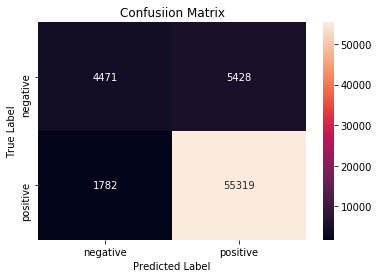

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.72      0.45      0.55      9899
          1       0.91      0.97      0.94     57101

avg / total       0.88      0.89      0.88     67000



In [48]:
# predict the response
y_pred_avgw2v = clf.predict(x_train_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train,y_pred_avgw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_train ,y_pred_avgw2v))

### Confusion Matrix for Test data

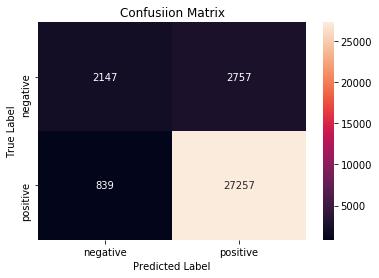

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.72      0.44      0.54      4904
          1       0.91      0.97      0.94     28096

avg / total       0.88      0.89      0.88     33000



In [49]:
# predict the response
y_pred_avgw2v = clf.predict(x_test_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_avgw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_test ,y_pred_avgw2v))

### RBF Kernel

In [50]:
#function for creating avg word2vector
from gensim.models import Word2Vec


list_of_sentance=[]
for sentance in x_train_rbf:
    list_of_sentance.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

x_train_avgw2v = np.array(sent_vectors)


In [51]:
list_of_sentance=[]
for sentance in x_test_rbf:
    list_of_sentance.append(sentance.split())
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sentance: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

x_test_avgw2v = np.array(sent_vectors)


(13400, 50)
(6600, 50)
Best tunned parameter is {'C': 1}
Train data accuracy is 85.885361% 


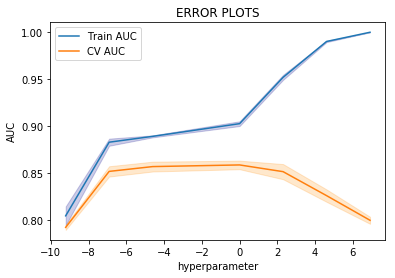

In [52]:
x_train_avgw2v_stand = scale.fit_transform(x_train_avgw2v)
x_test_avgw2v_stand = scale.transform(x_test_avgw2v)
print(x_train_avgw2v_stand.shape)
print(x_test_avgw2v_stand.shape)

optimal_c = optimal_lambda_val(x=x_train_avgw2v_stand,y=y_train_rbf,model = SVC(),parameters = parameters_rbf)

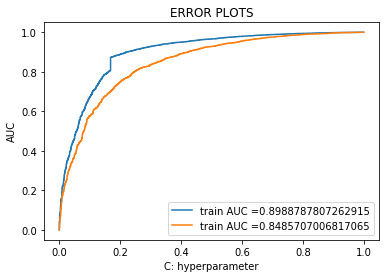

In [53]:
clf = SVC(C=optimal_c['C'],probability = True)
clf.fit(x_train_avgw2v_stand, y_train_rbf)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train_rbf, clf.predict_proba(x_train_avgw2v_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_rbf, clf.predict_proba(x_test_avgw2v_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix for train data

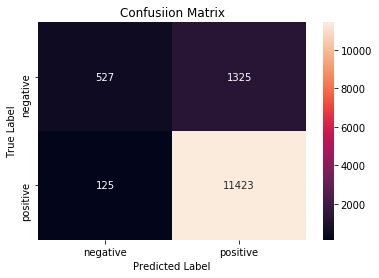

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.81      0.28      0.42      1852
          1       0.90      0.99      0.94     11548

avg / total       0.88      0.89      0.87     13400



In [54]:
# predict the response
y_pred_avgw2v = clf.predict(x_train_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_rbf,y_pred_avgw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_train_rbf ,y_pred_avgw2v))

### Confusion Matrix for test data

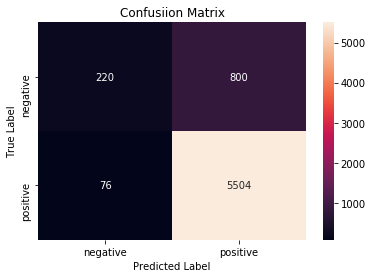

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.74      0.22      0.33      1020
          1       0.87      0.99      0.93      5580

avg / total       0.85      0.87      0.83      6600



In [55]:
# predict the response
y_pred_avgw2v = clf.predict(x_test_avgw2v_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_rbf,y_pred_avgw2v)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_test_rbf ,y_pred_avgw2v))

## TF-IDF Weighted W2V

### Linear Kernel

### Creating a tf-idf weighted w2v for train data

In [59]:
model = TfidfVectorizer()
model.fit_transform(x_train)

<67000x30910 sparse matrix of type '<class 'numpy.float64'>'
	with 2041534 stored elements in Compressed Sparse Row format>

In [60]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
list_of_sentance=[]
for sentance in x_train:
    list_of_sentance.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance: # for ea1ch review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
x_train_weighted = tfidf_sent_vectors

### Using the train model on test data

In [61]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
list_of_sentance=[]
for sentance in x_test:
    list_of_sentance.append(sentance.split())

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
x_test_weighted = tfidf_sent_vectors

(67000, 50)
(33000, 50)
Best tunned parameter is {'alpha': 0.01}
Train data accuracy is 87.081759% 


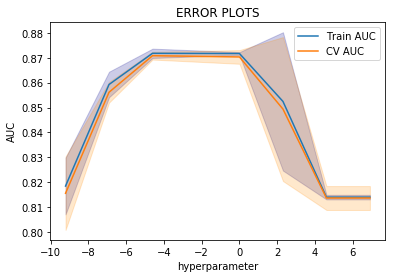

In [62]:
x_train_weighted_stand = scale.fit_transform(x_train_weighted)
x_test_weighted_stand = scale.fit_transform(x_test_weighted)
print(x_train_weighted_stand.shape)
print(x_test_weighted_stand.shape)
optimal_alpha = optimal_lambda_val(x=x_train_weighted_stand,y=y_train,model = SGDClassifier(),parameters = parameters_linear)

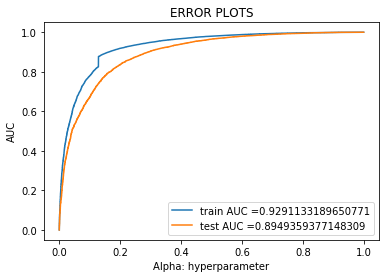

In [64]:
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV

sgd = SGDClassifier(alpha=optimal_alpha['alpha'])
sgd.fit(x_train_weighted_stand, y_train)
cl = CalibratedClassifierCV(base_estimator = sgd,cv = 'prefit')
clf.fit(x_train_weighted_stand, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, clf.predict_proba(x_train_weighted_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test_weighted_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("Alpha: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix on Train data

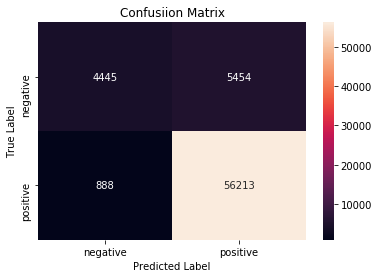

------------------------------------------------------
             precision    recall  f1-score   support

          0       0.83      0.45      0.58      9899
          1       0.91      0.98      0.95     57101

avg / total       0.90      0.91      0.89     67000



In [65]:
# predict the response
y_pred_weighted = clf.predict(x_train_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train,y_pred_weighted)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('------------------------------------------------------')
print(classification_report(y_train ,y_pred_weighted))

### Confusion Matrix on Test data

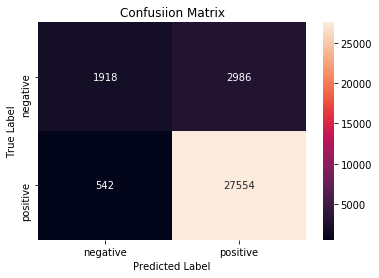

------------------------------------------------------
             precision    recall  f1-score   support

          0       0.78      0.39      0.52      4904
          1       0.90      0.98      0.94     28096

avg / total       0.88      0.89      0.88     33000



In [66]:
# predict the response
y_pred_weighted = clf.predict(x_test_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred_weighted)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('------------------------------------------------------')
print(classification_report(y_test ,y_pred_weighted))

### RBF Kernel

In [67]:
model = TfidfVectorizer()
model.fit_transform(x_train_rbf)

<13400x14445 sparse matrix of type '<class 'numpy.float64'>'
	with 402304 stored elements in Compressed Sparse Row format>

### Creating Tf-Idf weighted W2V for Train Data

In [68]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
list_of_sentance=[]
for sentance in x_train_rbf:
    list_of_sentance.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance: # for ea1ch review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
x_train_weighted = tfidf_sent_vectors

In [69]:
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
list_of_sentance=[]
for sentance in x_test_rbf:
    list_of_sentance.append(sentance.split())

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in list_of_sentance: # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1
x_test_weighted = tfidf_sent_vectors

(13400, 50)
(6600, 50)
Best tunned parameter is {'C': 1}
Train data accuracy is 83.542493% 


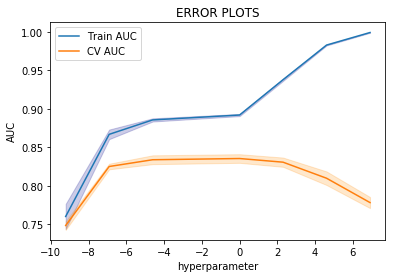

In [70]:
x_train_weighted_stand = scale.fit_transform(x_train_weighted)
x_test_weighted_stand = scale.fit_transform(x_test_weighted)
print(x_train_weighted_stand.shape)
print(x_test_weighted_stand.shape)

optimal_c = optimal_lambda_val(x=x_train_weighted_stand,y=y_train_rbf,model = SVC(),parameters = parameters_rbf)

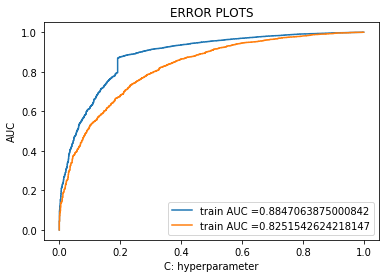

In [71]:
clf = SVC(C=optimal_c['C'],probability = True)
clf.fit(x_train_weighted_stand, y_train_rbf)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train_rbf, clf.predict_proba(x_train_weighted_stand)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_rbf, clf.predict_proba(x_test_weighted_stand)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="train AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("C: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

### Confusion Matrix for Train Data

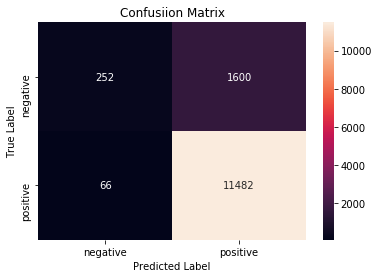

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.79      0.14      0.23      1852
          1       0.88      0.99      0.93     11548

avg / total       0.87      0.88      0.84     13400



In [74]:
# predict the response
y_pred_weighted = clf.predict(x_train_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_rbf,y_pred_weighted)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_train_rbf ,y_pred_weighted))

### Confusion Matrix for Test Data

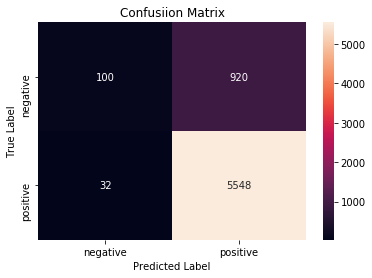

-----------------------------------------------------------
             precision    recall  f1-score   support

          0       0.76      0.10      0.17      1020
          1       0.86      0.99      0.92      5580

avg / total       0.84      0.86      0.81      6600



In [75]:
# predict the response
y_pred_weighted = clf.predict(x_test_weighted_stand)

#confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_rbf,y_pred_weighted)
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

print('-----------------------------------------------------------')
print(classification_report(y_test_rbf ,y_pred_weighted))

# Conclusion

In [76]:
#http://zetcode.com/python/prettytable/
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer ", "Kernel(Model)", "Hyper Parameter", "Train AUC","Test AUC"]
x.add_row(["BOW", "Linear(SGD)", .001,95,93])
x.add_row(["BOW", "RBF(SVC)",10,93.5,88.8])
x.add_row(["TF-IDF", "Linear(SGD)",.0001,97,95])
x.add_row(["TF-IDF", "RBF(SVC)",100,91.7,88.6])
x.add_row(["AVG W2V", "Linear(SGD)",.01,90.3,90])
x.add_row(["AVG W2V", "RBF(SVC)",1,89.8,84.8])
x.add_row(["TF-IDF weighted W2V", "Linear(SGD)",.01,92.9,89.5])
x.add_row(["TF-IDF weighted W2V", "RBF(SVC)",1,88.5,82.5])

print(x)

+---------------------+---------------+-----------------+-----------+----------+
|     Vectorizer      | Kernel(Model) | Hyper Parameter | Train AUC | Test AUC |
+---------------------+---------------+-----------------+-----------+----------+
|         BOW         |  Linear(SGD)  |      0.001      |     95    |    93    |
|         BOW         |    RBF(SVC)   |        10       |    93.5   |   88.8   |
|        TF-IDF       |  Linear(SGD)  |      0.0001     |     97    |    95    |
|        TF-IDF       |    RBF(SVC)   |       100       |    91.7   |   88.6   |
|       AVG W2V       |  Linear(SGD)  |       0.01      |    90.3   |    90    |
|       AVG W2V       |    RBF(SVC)   |        1        |    89.8   |   84.8   |
| TF-IDF weighted W2V |  Linear(SGD)  |       0.01      |    92.9   |   89.5   |
| TF-IDF weighted W2V |    RBF(SVC)   |        1        |    88.5   |   82.5   |
+---------------------+---------------+-----------------+-----------+----------+


# Observation

## BOW
- worst,disappoint,aw,terribl,threw,return,unfortun,disgust,horribl,wast re top negative words
- delici,amaz,perfect,excel,great,addict,best,worri,nice,awesom are top positive words

## TF-IDF
- disappoint,worst,return,aw,terribl,threw,horribl,wast,unfortun,money are top negative words
- great,love,best,delici,good,perfect,nice,excel,amaz,wont disappoint are top positive words

-----------------------------------------------------------------------------------------------------------
# General

- Linear Kernel is giving better AUC over test data than RBF
- Linear runs  faster than RBF
- SGD classifier didn't provide probabilty attribute so to plot AUC we used CallibratedClassifierCV 
  using base_estimator as SGDClassifier
- SVC() takes more time if probability parameter is true

  